<img src="https://drive.google.com/uc?id=1dFgNX9iQUfmBOdmUN2-H8rPxL3SLXmxn" width="400"/>


---


# **Deep Reinforcement Learning**


#### **Contents/agenda**

1. What is Reinforcement Learning?
2. What is Deep RL?
3. How is RL different from Supervised and Unsupervised Learning?
4. Types of (Deep) RL algorithms.
5. Implementing a Deep RL algorithm.



#### **Learning outcomes**

1. Understand the basic concepts used in RL papers and algorithms
2. Understand the different components of RL problems.
3. Understand the differences between RL and other types of learning.
4. Understand how Deep Learning could have a role in RL.
5. Learn how to implement a  simple Deep RL algorithm.


<br/>

---

<br/>

In [ ]:
%matplotlib notebook

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
from torchsummary import summary

import numpy as np
from PIL import Image
from pathlib import Path
from collections import deque
import matplotlib.pyplot as plt
import random, time, datetime, os, copy
from IPython.display import display, clear_output
from IPython.html.widgets import interactive



/usr/local/lib/python3.8/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## What is Reinforcement Leaning?

Reinforcement Learning (RL) is a much larger field than Deep RL, so let's start by reviewing some what RL is and some of its core concepts. This will allow you to better undersand Deep RL and literature on the topic.

Our goal in artificial intelligence is, arguably, to allow machines to find solutions to problems themselves, so that we only need to specify the problem setting or the goal. This requires autonomous learning of decision-making processes in order to achieve these goals. That is, we need to develop systems that are able to learn to make good sequences of decisions (usually under uncertainty). 

RL is the study of agents that can learn by trial an error how to make good seqeunces of decisions. It involves:

- optimisation - learning to make decisions that have optimal consequences;
- delayed consequences - the agent might not know if it made a good decision until much later;
- exploration - the agent learns about the world by making decisions within the it and, in the process, altering the world with its decisions;
- generalisation - the agent needs to learn to make decisions that can generalise beyond the experience lived.


### RL concepts

<img src="https://drive.google.com/uc?id=1pVsXYC39_Xbn9_PZ4a4vmq6AVu21_L--" width="700"/>

The main characters in our RL worldview are the **agent** and the **environment**. The environment is the world in which the agent lives. The agent interacts with the enviroment through actions $A_t$ and receives information about the environment through observations $O_t$ and through (scalar) rewards $R_t$. 

We usually divide the interaction process between agent and environment in a series of discrete steps, with each step denoted by the subscript $t$ in our notation. 

This does **not** mean that what we see here is an RNN: this is an abstract representation of the problem that we are trying to pose, and not of the algorithm or model that we use to solve the problem.

Although it is usual to have discrete action sequences, there are extensions of RL that work with with continuous interactions. We will not look at these in this class.


#### **The state**

<img src="https://drive.google.com/uc?id=1L1Ajt1EfXZoMXiVnVogxlkecwyw7ffDn" width="700"/>

There are two states that we talk about in RL. The **state of the environment**, which might or might not be known to the agent, and which might be partially or completely observable by the agent. The **state of the agent**, which it keeps as a way to understand its situation within the world. Both the environment and agent states could be deterministic or stochastic.

Now, what should the state of the agent contain in order for it to keep track of its situation? To answer that, we first need to understand what is the **history**. The history is the full sequence of observations, actions and rewards:

$$\mathcal{H}_t = \{O_0, A_0, R_1, O_1, A_1, R_2, ..., O_{t-1}, A_{t-1}, R_t, O_t\}$$

The state of the agent is only a function of the history. Depending on the amount of information that the observations provide to the agent, we also need to consider specific cases: full observability, where the observation is the full environment state (for example, if we have an agent that plays chess or go); partial observability, where the observation is only a limited view of the environment state (for example, if our agent is a robot with a camera or a poker-playing agent that can only see its own cards).

So, how much information should the state of the agent contain? Generally in RL, we assume that our problem is a **Markov decision process (MDP)**, which allows us to more easily reason about our problems and pose algorithms to solve them by limiting the amount of information stored in the agent state. A decision process is MDP if,

$$p(r, s | S_t, A_t) = p(r, s | \mathcal{H}_t, A_t)$$

That is, if the probability of a reward $r$ and subsequent state $s$ depends only on the current state and action, and not on the entire history. Or, what is the same, that the state contains all relevant information that we need to know from the history. This is not to say that the state contains everything, only that adding more information to it does not help. This is very useful because the history might be very large (in terms of computer memory), whereas the state might be much smaller. 

The trivial example of MDP is one in which $S_t = \mathcal{H}_t$, but obviously that is not very useful. Instead, the state is normally some form of compression of the history. Can you think of a way in which you could create such a compression in practice?

In partially observable environments, we can extend the concept of MDP to partialy observable Markov decision processes (POMDP), which we are not going to look at rigorously.

<img src="https://drive.google.com/uc?id=1JXapof376b0ZSq5HYczN7AL1DWSANN0B" width="700"/>

#### **The policy**

<img src="https://drive.google.com/uc?id=1VN-bnqtFdq5cvrlncMv2n3RWn70P53Zh" width="700"/>

A mapping from states to actions is called a **policy**, and it defines the behaviour of the agent. Policies can be deterministic:

$$A_t = \mu(S_t)$$

and they can be stochastic:

$$A_t \backsim \pi(\cdot | S_t)$$


#### **The value**

RL is based on the reward hypothesis, which states that: 

>*Any goal can be formalised as the outcome of maximising a cumulative reward.*

Think about it - can you find a counter-example for this? 

In order to pose RL problems and create algorithms to solve them, we will have figure out what is the most appropriate reward function so that maximising it allows the agent to reach the expected goal.

Some examples of problems and their associated reward functions:

- Fly a felicopter - air time, inverse distance, ...
- Manage an investent portfolio - gains, gains minus risk, ...
- Make a robot walk - distance, speed, lack of accidents, ...
- Play a game - win, maximise score, ...

The **goal**, or more commonly the **return** in RL lingo, is then the sum of all (discounted) future instantatenous rewards:

$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ...$$

for the discount factor $\gamma \in [0, 1]$, which trades the importance of immediate vs long-term rewards. Actions cannot influence the past, only the future, so the goodness of an action can only be measured by looking at its impact in future rewards.

We cannot always observe the return, and instead we look at its expectation given that we are currently at a given state, which we call the **value function** or **state value function**:

$$V(s) = \mathbb{E}[G_t | S_t = s] =\\ \mathbb{E}[R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... | S_t = s]$$

If we condition the value also on the actions we can also write the **state-action value function**:

$$Q(s, a) = \mathbb{E}[G_t | S_t = s, A_t = a] =\\ \mathbb{E}[R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... | S_t = s, A_t = a]$$

Any goal can then be achieved by maximising the value, which depends on the states and actions taken. There is no supervised feedback, though, no one is saying whether actions are correct or incorrect, only whether they lead to maximising the reward.

Given a certain policy, the dependency of these value functions on the policy is usually expressed as:

$$V_\pi(s) = \mathbb{E}[G_t | S_t = s, \pi] =\\ \mathbb{E}[R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... | S_t = s, \pi]$$

&nbsp;

$$Q_\pi(s, a) = \mathbb{E}[G_t | S_t = s, A_t = a] =\\ \mathbb{E}[R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... | S_t = s, A_t = a, \pi]$$

&nbsp;

which explicitly says that these are the value functions given that all future actions are selected given some policy $\pi$.


#### **Bellman equations**

The value functions can be expressed in a resursive form, leading to the **Bellman equations**:

$$V_\pi(s) = \mathbb{E}[R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... | S_t = s, \pi] =\\
\mathbb{E}[R_{t+1} + \gamma V_\pi(S_{t+1}) | S_t = s, \pi]$$

&nbsp;

$$Q_\pi(s, a) = \mathbb{E}[R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... | S_t = s, A_t = a, \pi] =\\
\mathbb{E}[R_{t+1} + \gamma Q_\pi(s_{t+1}, a_{t+1}) | S_t = s, A_t = a, \pi]$$

&nbsp;

Similar equations can be written for the optimal values:

$$V^*(s) = \max_a \mathbb{E}[R_{t+1} + \gamma V^*(S_{t+1}) | S_t = s]$$

&nbsp;

$$Q^*(s, a) = \max_a \mathbb{E}[R_{t+1} + \gamma Q^*(S_{t+1}, A_{t+1}) | S_t = s, A_t = a]$$

&nbsp;

which do not depend on the policy.

These equations are the basis for most RL algorithms.


#### **The learning in Reinforcement Learning**

We have seen the different components of an RL problem and how we can measure the idoneity of action sequences, but we haven't looked yet at what the agent will actually be learning when we pose our RL algorithms.

When developing RL algorithms, there are a number of different components that an agent can learn in order to choose optimal actions. These usually are:

- The policy
- The state value function
- The action-state value function
- A model of the state of the environment
- A model of how the agent state will evolve

Depending on the one or multiple components that our agent learns, we will obtain different types of RL algorithms.


## What is Deep Reinforcement Learning?

In this course, we have seen how deep learning is extremely useful tool to encode, decompose, transform data in order to reason about it and extract useful features from it. Deep RL then emerges from using these deep neural networks in order to represent, learn, and inform the different components of our agent within the framework of RL. 

Why could this be a good idea? 

It allows us to use neural network's characteristics, thanks for the universal function approximation theorem, to create more complex and sophisticated agents that can better reason about very high-dimensional spaces that are closer to real life.

For example, let's say we have a robot agent that has uses a camera to observe the environment and that the camera produces RGB images of size 100x200. What would be the space of possible inputs of our RL agent if it only used one image at a time? $(256^{100x200})^3$

The idea of using neural networks in RL is not new. It was originally proposed in the 1990s [1], but never gained much traction. It wasn't until the mid-2010s that DeepMind showed that it was possible to use neural networks successfully to solve RL problems with very high-dimensional outputs by training networks to play Atari games with, in many cases, better performance than humans [2].

In [ ]:
%%html
<iframe src="https://www.youtube.com/embed/Q70ulPJW3Gk" width="600", height="400"></iframe>

Since then, there have been incredible advances in Deep RL, including the famous Alpha* family (AlphaGo, AlphaZero, AlphaTensor). 

<img src="https://drive.google.com/uc?id=13eqryeyFtLn9B-8vM7J7u6pdHc3pnwm_" width="500"/>


## How is RL different from Supervised and Unsupervised Learning?

We could think of RL as learning by experience vs other forms of learning in which the model learns by example.

We can also understand these differences by looking at the characteristics of RL, which we introduced before:

- optimisation;
- delayed consequences;
- exploration;
- generalisation.

And we can compare that with those of supervised:

- optimisation;
- generalisation;
- learning by example, but with correct labels provided;

and unsupervised learning:

- optimisation;
- generalisation;
- learning by example, but with no labels from the world;

In neither of them there exists exploration, while consequences are immediate instead of delayed, example by example.


## Types of (Deep) RL algorithms

<img src="https://spinningup.openai.com/en/latest/_images/rl_algorithms_9_15.svg" width="700"/>

## Implementing a Deep RL algorithm

<img src="https://drive.google.com/uc?id=1Lc2ZuEMNvKyj7NW55Yi6z8S-qOwK7WIb" width="300"/>

In this practical, we are going to train a Deep RL model to play Mario! Our implementation is inspired by the one found in the [PyTorch documentation.](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html)

We will use a network to learn a model of the optimal Q state-action value function. The rationale for doing this is that, if we know the value of taking a certain action at a certain state, it will be possible to choose optimal actions based on this model.


### OpenAI Gym

We will get access to a predefined environment for our agent to play Mario by using [OpenAI's gym](https://github.com/openai/gym), an open-source Python library that provides a standard API to communicate between RL agents and a set of standard envinments, including many games.

In [ ]:
%%bash
pip install gym-super-mario-bros==7.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

### The environment

Let's start by initialising our environment:

In [ ]:
# Initialize Super Mario environment (in v0.26 change render mode to 'human' to see results on the screen)
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb', apply_api_compatibility=True)

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(


In this setting, our agent will interact with the environment through a series of predetermined valid actions. For this example, we will limit the valid actions to `walk right` and `jump right`.

In [ ]:
# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



In turn, the Mario environment will offer the agent the opportunity to observe its state by looking at the instantenous game screen, an RGB image of size `[3, 240, 256]`.

The environment will also provide some other information to the agent, such as coins obtained, lives remaining, time spent, whether the character is small or large, etc.

In [ ]:
# reset the environment
# test taking a step
# print information returned by the environment

(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


Because the information that our agent needs to extract from the screen does not depend, for the most part, on its colour, we will need to preprocess these to make them grayscale. We will also reduce the size of this data stream by downsampling the images and by skipping some of the frames.

OpenAI's gym has a number of wrappers that allow us to do this easily:

In [ ]:
class SkipFrame(gym.Wrapper):

    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0

        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            # for skipped frames
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break

        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):

    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)

        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = transforms.Grayscale()
        observation = transform(observation)

        return observation


class ResizeObservation(gym.ObservationWrapper):

    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        t = transforms.Compose(
            [transforms.Resize(self.shape), transforms.Normalize(0, 255)]
        )
        observation = t(observation).squeeze(0)

        return observation

env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)

We will also use a `FrameStack` wraper to accumulate multiple consecutive frames before giving them to our agent. This will allow it to understand patterns such as direction of movement.

In [ ]:
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

### The agent

We have created an environment to interact with and, now, we need to create an agent that can interact with this environment and learn from it.

At the end of this exercise, we will encapsulate the agent in a class but, before we do that, let's introduce some key practical aspects of training Deep RL networks and some of the code that we will use to implement them.

#### **Exploration vs exploitation**

Our agent is going to learn a model of the Q value function, based on which it will choose optimal actions at any given state. 

Given a model of the value function, the optimal action should be that which maximises the expected return. However, in order to obtain a representative and complete model of the value function, the agent should also explore the range of possible actions at any given state in order to construct a better model.

Therefore, the agent needs to balance between *exploration* ang *exploitation*. When an agent explores, it gets more accurate estimates of action-values. And when it exploits, it might get more reward. It cannot, however, choose to do both simultaneously, which is also called the exploration-exploitation dilemma.

We solve this dilemma by using what is called an **$\epsilon$-greedy policy**, a simple method to balance exploration and exploitation. Under this policy, the agent will choose between exploration and exploitation randomly with a probability $\epsilon$. Ideally, we want to balance $\epsilon$ so that the agent explores more at the beginning of our training and gradually exploits more as it progresses.

In [ ]:
exploration_rate = 1
exploration_rate_decay = 0.99999975
exploration_rate_min = 0.1
curr_step = 0

def act(state):
    # randomly choose whether to explore or exploit, given the exploration rate
    # EXPLORE
    # randomly choose an action

    # EXPLOIT
    # use the network to predict the Q value for each action
    # select the action with the maximum Q value

    # decrease exploration_rate

    # increment step

    return action_idx


#### **Experience replay**

The success of the original DQN network can be partly attributed to the introduction of experience replay. When the agent performs an action, it will store the results of that action into a memory table. 

During training, instead of only looking at the current game, the agent will pull a random element from its memory and replay it, learning (possibly multiple times) from it.

This makes sure previous experience is not lost and overwritten throughout the training process. It also improves convergence by making the learning examples more `i.i.d.`, which is a key assumption when training neural networks.


In [ ]:
memory = deque(maxlen=100000)
batch_size = 32

def cache(state, next_state, action, reward, done):
    def first_if_tuple(x):
        return x[0] if isinstance(x, tuple) else x

    state = first_if_tuple(state).__array__()
    next_state = first_if_tuple(next_state).__array__()

    # copy all cached elements into new tensors

    # append to the memory

def recall():
    # randomly sample as many memories as the size of our batch
    # stack the memories

    return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()


#### **DDQN algorithm**

The DDQN algorithm is an improvement over the original Atari-playing DQN. 

Both the original DQN and DDQN use a network to learn a Q function, using the Bellman equation as a basis to formulate a loss. If we recall the Bellman equation:

$$Q_\pi(s, a) = \mathbb{E}[R_{t+1} + \gamma Q_\pi(s_{t+1}, a_{t+1}) | S_t = s, A_t = a, \pi]$$

we can use it to write the following loss function:

$$L = || (R_{t+1} + \gamma \max_{A_{t+1}} Q(S_{t+1}, A_{t+1})) - Q(S_t, A_t) ||_{p}$$

where the left side $R_{t+1} + \gamma \max_{A_{t+1}} Q(S_{t+1}, A_{t+1})$ is called the target and the right side $Q(S_t, A_t)$ is called the prediction.

Computing this loss, however, poses some problems: the Q function being learned is present both in the target and prediction. This can make the training unstable. The DDQN algorithm solves this by introducing a second Q network, $Q_{target}$, that is only update network with the weights of the primary Q network, $Q_{prediction}$ every n number of timesteps.

The loss function then becomes:

$$L = || (R_{t+1} + \gamma \max_{A_{t+1}} Q_{target}(S_{t+1}, arg\max_a Q_{prediction}(S_{t+1}, A_{t+1}))) - Q_{prediction}(S_t, A_t) ||_{p}$$

In [ ]:
class MarioNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        # create the Q_prediction network

        # create the Q_target network

        # Q_target parameters are frozen

    def forward(self, input, model):
        # select network appropriately

### **The loss function**

To calculate the loss function, we need to calculate the prediction and target portions of it.

The prediction will be given by our estimated optimal Q funcion for a given state $S_t$:

$$L_{prediction} = Q_{prediction}(S_t, A_t)$$

The target will be obtained by summing the current reward and the estimated function given the next state and action:

$$L_{target} = R_{t+1} + \gamma Q_{target}(S_{t+1}, A_{t+1})$$

where $A_{t+1} = arg\max_{a} Q_{prediction}(S_{t+1}, A_{t+1})$ because the next action is not known at this stage.

In [ ]:
gamma = 0.9

def l_prediction(state, action):
    # Q_prediction(s,a)

    return current_Q

# remember, no update should be applied to Q_target,
# so we need to deactivate grads
@torch.no_grad()
def l_target(reward, next_state, done):
    # predict the next action that will be taken

    # calculate the associated target Q value

    # calculate l_target


We will also need to consider how to update $Q_{prediction}$ and $Q_{target}$:

In [ ]:
def update_Q_prediction(l_estimate, l_target):
    # calculate the difference betweeen both parts of the loss

    # backpropagate

    # update params

    return loss.item()

def sync_Q_target():
    # sync weights between two networks


Now, let's put all of it together! This will be our agent class `Mario`:

In [ ]:
class Mario:

    def __init__(self, state_dim, action_dim, save_dir, checkpoint=None):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=10000)
        self.batch_size = 32

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.gamma = 0.9

        self.curr_step = 0
        self.burnin = 1e2  # min. experiences before training
        self.learn_every = 3   # no. of experiences between updates to Q_prediction
        self.sync_every = 1e4   # no. of experiences between Q_target & Q_prediction sync

        self.save_every = 5e5   # no. of experiences between saving Mario Net
        self.save_dir = save_dir

        self.use_cuda = torch.cuda.is_available()

        # Mario's DNN to predict the most optimal action
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=device)

        if checkpoint:
            self.load(checkpoint)

        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)  # use Adam optimiser
        self.loss_fn = torch.nn.SmoothL1Loss()  # use L1 loss

    def act(self, state):
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=device).unsqueeze(0)
            action_values = self.net(state, model='prediction')
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

    def cache(self, state, next_state, action, reward, done):
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x

        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(state, device=device)
        next_state = torch.tensor(next_state, device=device)
        action = torch.tensor([action], device=device)
        reward = torch.tensor([reward], device=device)
        done = torch.tensor([done], device=device)

        self.memory.append( (state, next_state, action, reward, done,) )

    def recall(self):
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))

        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

    def l_estimate(self, state, action):
        current_Q = self.net(state, model='prediction')[np.arange(0, self.batch_size), action] # Q_prediction(s,a)

        return current_Q

    @torch.no_grad()
    def l_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model='prediction')
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model='target')[np.arange(0, self.batch_size), best_action]

        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

    def update_Q_prediction(self, l_estimate, l_target) :
        loss = self.loss_fn(l_estimate, l_target)

        self.optimizer.zero_grad()
        loss.backward()

        self.optimizer.step()

        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.prediction.state_dict())

    def learn(self):
        # sync networks if needed
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        # save checkpoint if needed
        if self.curr_step % self.save_every == 0:
            self.save()

        # only start learning when we have enough initial experiences stored
        if self.curr_step < self.burnin:
            return None, None

        # only learn every n steps
        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory

        # Get L Estimate

        # Get L Target

        # Backpropagate loss through Q_prediction


    def save(self):
        save_path = self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        torch.save(
            dict(
                model=self.net.state_dict(),
                exploration_rate=self.exploration_rate
            ),
            save_path
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

    def load(self, load_path):
        if not load_path.exists():
            raise ValueError(f"{load_path} does not exist")

        ckp = torch.load(load_path, map_location=('cuda' if self.use_cuda else 'cpu'))
        exploration_rate = ckp.get('exploration_rate')
        state_dict = ckp.get('model')

        print(f"Loading model at {load_path} with exploration rate {exploration_rate}")
        self.net.load_state_dict(state_dict)
        self.exploration_rate = exploration_rate

### Training

Before we train, let's create a utility function to log the results of our training.

In [ ]:
class MetricLogger:

    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

And let's see how our agent performs after running for 10 episodes:


In [ ]:
save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 20
for e in range(episodes):
    state = env.reset()

    # Play the game!
    while True:
        # Run agent on the state

        # Agent performs action

        # Remember

        # Learn

        # Logging

        # Update state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()
    logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

Episode 0 - Step 40 - Epsilon 0.9999900000487484 - Mean Reward 231.0 - Mean Length 40.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.349 - Time 2022-12-12T17:46:40


<IPython.core.display.Javascript object>

Episode 1 - Step 269 - Epsilon 0.9999327522528155 - Mean Reward 631.0 - Mean Length 134.5 - Mean Loss 1.176 - Mean Q Value 2.682 - Time Delta 4.719 - Time 2022-12-12T17:46:45
Episode 2 - Step 1359 - Epsilon 0.9996603076659931 - Mean Reward 618.0 - Mean Length 453.0 - Mean Loss 1.362 - Mean Q Value 2.648 - Time Delta 20.705 - Time 2022-12-12T17:47:05
Episode 3 - Step 1623 - Epsilon 0.9995943322546434 - Mean Reward 717.75 - Mean Length 405.75 - Mean Loss 1.172 - Mean Q Value 2.467 - Time Delta 3.18 - Time 2022-12-12T17:47:09
Episode 4 - Step 2109 - Epsilon 0.9994728889059106 - Mean Reward 771.2 - Mean Length 421.8 - Mean Loss 1.041 - Mean Q Value 2.355 - Time Delta 5.619 - Time 2022-12-12T17:47:14
Episode 5 - Step 2423 - Epsilon 0.999394433353734 - Mean Reward 859.167 - Mean Length 403.833 - Mean Loss 0.961 - Mean Q Value 2.289 - Time Delta 3.702 - Time 2022-12-12T17:47:18
Episode 6 - Step 2463 - Epsilon 0.9993844394581194 - Mean Reward 769.429 - Mean Length 351.857 - Mean Loss 0.914 - M

### Replay

Let's test our model's ability to play Mario:

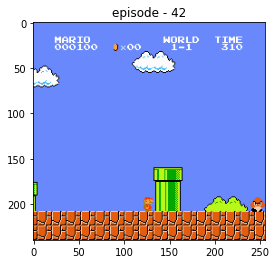

In [ ]:
%matplotlib inline

# make sure there is no exploration when replaying

episodes = 100

fig,ax = plt.subplots(1,1)
hdisplay = display("", display_id=True)
fig, ax = plt.subplots(1, 1)

def plot(_env, _img):
    _img.set_data(_env.render(mode='rgb_array'))
    time.sleep(1e-3)
    hdisplay.update(fig)

for e in range(episodes):

    state = env.reset()
    img = ax.imshow(env.render(mode='rgb_array'))
    plt.title('episode - %d' % e)

    while True:
        plot(env, img)

        action = mario.act(state)

        next_state, reward, done, trunc, info = env.step(action)
        state = next_state

        if done or info['flag_get']:
            break

## Further resources

These are some very good courses on RL that touch on Deep RL as well:

- [Stanford's RL course](http://web.stanford.edu/class/cs234/index.html)
- [UCL+DeepMind's RL course](https://www.deepmind.com/learning-resources/introduction-to-reinforcement-learning-with-david-silver)

OpenAI also has a very interesting [project](https://spinningup.openai.com/en/latest/user/introduction.html) in which they implement many RL algorithms using PyTorch and TensorFlow.

Most of this notebook has been generated based on these resources.

## References

1. Gerald Tesauro, "TD-Gammon, a self-teaching backgammon program, achieves master-level play", 1994 - [https://dl.acm.org/doi/10.1162/neco.1994.6.2.215](https://dl.acm.org/doi/10.1162/neco.1994.6.2.215)
2. Volodymyr Mnih, Koray Kavukcuoglu, David Silver, Alex Graves, Ioannis Antonoglou, Daan Wierstra, Martin Riedmiller, "Playing Atari with Deep Reinforcement Learning", 2013 - [https://arxiv.org/abs/1312.5602](https://arxiv.org/abs/1312.5602)